In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler


from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score, confusion_matrix, recall_score

# Exploratory Data Analysis, Data Pre Processing and Feature selection

In [2]:
df = pd.read_csv('train.csv').set_index('encounter_id')

In [3]:
train = df.drop(columns = ['readmitted_binary', 'readmitted_multiclass'])
target_multiclass = df['readmitted_multiclass']
target_binary = df['readmitted_binary']

In [88]:
X_test = pd.read_csv('test.csv').set_index('encounter_id')

In [89]:
train.head()

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,2,...,20,515,276,466,8,NaN,NaN,No,No,[]
426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,0,...,25,38,785,162,9,NaN,NaN,No,Yes,['insulin']
634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,1,...,22,534,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']"
890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,1,...,9,569,562,455,5,NaN,NaN,No,No,[]
654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,0,...,15,715,599,428,9,NaN,NaN,No,No,[]


### Looking for the data

In [90]:
train.shape

(71236, 28)

In [91]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,71236.0,5.430228e+07,3.879585e+07,135.0,23396510.25,45305631.0,87558374.25,189502619.0
outpatient_visits_in_previous_year,71236.0,3.695884e-01,1.287469e+00,0.0,0.00,0.0,0.00,42.0
emergency_visits_in_previous_year,71236.0,1.962491e-01,9.108537e-01,0.0,0.00,0.0,0.00,76.0
inpatient_visits_in_previous_year,71236.0,6.401539e-01,1.267271e+00,0.0,0.00,0.0,1.00,21.0
average_pulse_bpm,71236.0,9.961122e+01,2.304052e+01,60.0,80.00,100.0,119.00,139.0
length_of_stay_in_hospital,71236.0,4.391024e+00,2.988739e+00,1.0,2.00,4.0,6.00,14.0
number_lab_tests,71236.0,4.309565e+01,1.964292e+01,1.0,31.00,44.0,57.00,121.0
non_lab_procedures,71236.0,1.340923e+00,1.706664e+00,0.0,0.00,1.0,2.00,6.0
number_of_medications,71236.0,1.599545e+01,8.122347e+00,1.0,10.00,15.0,20.00,75.0
number_diagnoses,71236.0,7.421023e+00,1.937809e+00,1.0,6.00,8.0,9.00,16.0


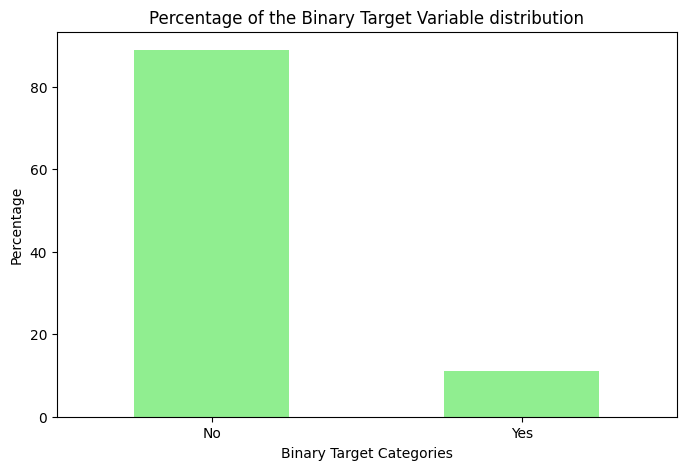

In [92]:
target_distribution = target_binary.value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
target_distribution.plot(kind='bar', color='lightgreen')
plt.title('Percentage of the Binary Target Variable distribution')
plt.xlabel('Binary Target Categories')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

We have an imbalanced target.

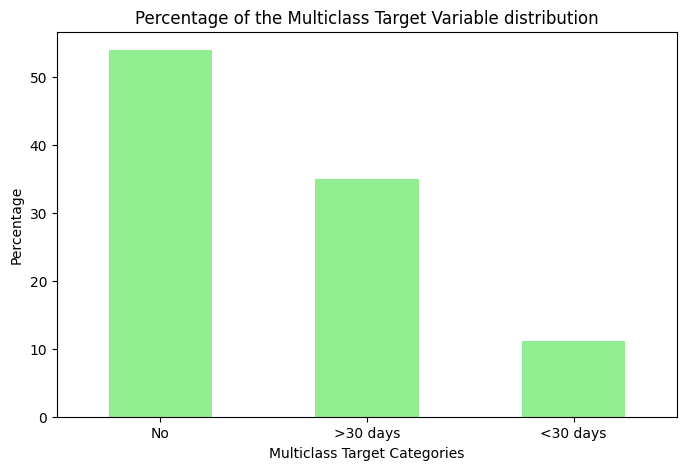

In [4]:
target_distribution = target_multiclass.value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
target_distribution.plot(kind='bar', color='lightgreen')
plt.title('Percentage of the Multiclass Target Variable distribution')
plt.xlabel('Multiclass Target Categories')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [94]:
train.duplicated().sum()

0

### Searching for missing values

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71236 entries, 533253 to 459757
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                71236 non-null  object
 1   patient_id                             71236 non-null  int64 
 2   race                                   67682 non-null  object
 3   gender                                 71236 non-null  object
 4   age                                    67679 non-null  object
 5   weight                                 71236 non-null  object
 6   payer_code                             71236 non-null  object
 7   outpatient_visits_in_previous_year     71236 non-null  int64 
 8   emergency_visits_in_previous_year      71236 non-null  int64 
 9   inpatient_visits_in_previous_year      71236 non-null  int64 
 10  admission_type                         67530 non-null  object
 11  medical_specia

At first sight it doesn't seem to have much missing values.

In [96]:
train.head()

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,2,...,20,515,276,466,8,NaN,NaN,No,No,[]
426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,0,...,25,38,785,162,9,NaN,NaN,No,Yes,['insulin']
634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,1,...,22,534,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']"
890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,1,...,9,569,562,455,5,NaN,NaN,No,No,[]
654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,0,...,15,715,599,428,9,NaN,NaN,No,No,[]


Some missing values are represented by '?', let's fix them.

In [97]:
train.replace('?', np.nan, inplace=True)
X_test.replace('?', np.nan, inplace=True)

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71236 entries, 533253 to 459757
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                71236 non-null  object
 1   patient_id                             71236 non-null  int64 
 2   race                                   66166 non-null  object
 3   gender                                 71236 non-null  object
 4   age                                    67679 non-null  object
 5   weight                                 2246 non-null   object
 6   payer_code                             43035 non-null  object
 7   outpatient_visits_in_previous_year     71236 non-null  int64 
 8   emergency_visits_in_previous_year      71236 non-null  int64 
 9   inpatient_visits_in_previous_year      71236 non-null  int64 
 10  admission_type                         67530 non-null  object
 11  medical_specia

Now we have much more missing values. Let's see if we find other values that represent Missing values.

In [99]:
unique_values = {}
for i in train.columns:
    unique_values[i] = train[i].nunique()
unique_values

{'country': 1,
 'patient_id': 53985,
 'race': 5,
 'gender': 3,
 'age': 10,
 'weight': 9,
 'payer_code': 17,
 'outpatient_visits_in_previous_year': 38,
 'emergency_visits_in_previous_year': 30,
 'inpatient_visits_in_previous_year': 21,
 'admission_type': 7,
 'medical_specialty': 68,
 'average_pulse_bpm': 80,
 'discharge_disposition': 25,
 'admission_source': 16,
 'length_of_stay_in_hospital': 14,
 'number_lab_tests': 114,
 'non_lab_procedures': 7,
 'number_of_medications': 72,
 'primary_diagnosis': 686,
 'secondary_diagnosis': 698,
 'additional_diagnosis': 746,
 'number_diagnoses': 16,
 'glucose_test_result': 3,
 'a1c_test_result': 3,
 'change_in_meds_during_hospitalization': 2,
 'prescribed_diabetes_meds': 2,
 'medication': 303}

Since country has only 1 unique value we drop it.

In [100]:
train.drop('country', axis=1, inplace=True)
X_test.drop('country', axis=1, inplace=True)

In [101]:
train['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [102]:
train[train['gender'] == 'Unknown/Invalid']

,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
208080,78119847,NaN,Unknown/Invalid,[70-80),NaN,CP,0,0,0,Emergency,...,21,850,805,808,9,NaN,NaN,Ch,Yes,"['metformin', 'rosiglitazone']"
978787,60524946,NaN,Unknown/Invalid,[60-70),NaN,CP,0,0,0,Emergency,...,6,808,873,E813,5,NaN,NaN,No,No,[]
876217,100695042,Other,Unknown/Invalid,[70-80),NaN,NaN,0,0,0,Elective,...,22,414,411,401,4,NaN,NaN,Ch,Yes,"['glipizide', 'pioglitazone']"


In [103]:
train.replace('Unknown/Invalid', np.nan, inplace=True)
X_test.replace('Unknown/Invalid', np.nan, inplace=True)

print(train['gender'].unique())

#updating unique_values
unique_values['gender'] = train['gender'].nunique()

['Female' 'Male' nan]


In [104]:
object_columns = train.select_dtypes(include=['object']).columns.tolist()
for i in object_columns:
   print (i, train[i].unique())

race ['Caucasian' 'AfricanAmerican' 'Other' nan 'Hispanic' 'Asian']
gender ['Female' 'Male' nan]
age ['[70-80)' '[50-60)' '[60-70)' '[80-90)' nan '[40-50)' '[20-30)' '[30-40)'
 '[90-100)' '[10-20)' '[0-10)']
weight [nan '[50-75)' '[100-125)' '[75-100)' '[125-150)' '[25-50)' '>200'
 '[0-25)' '[150-175)' '[175-200)']
payer_code [nan 'MC' 'HM' 'UN' 'SP' 'SI' 'CM' 'DM' 'CP' 'MD' 'OG' 'BC' 'PO' 'WC' 'OT'
 'MP' 'CH' 'FR']
admission_type ['Emergency' nan 'Elective' 'Urgent' 'Not Available' 'Newborn'
 'Not Mapped' 'Trauma Center']
medical_specialty ['Family/GeneralPractice' nan 'InternalMedicine' 'Surgery-General'
 'Radiologist' 'Emergency/Trauma' 'Hematology' 'Nephrology' 'Orthopedics'
 'ObstetricsandGynecology' 'Psychiatry' 'Cardiology' 'Gastroenterology'
 'Psychology' 'Surgery-Thoracic' 'Orthopedics-Reconstructive'
 'Surgery-Vascular' 'PhysicianNotFound' 'Neurology'
 'PhysicalMedicineandRehabilitation' 'Pulmonology' 'Hematology/Oncology'
 'Oncology' 'Surgery-Neuro' 'Radiology' 'Urology' 'Pe

We se that some features have 'Not Mapped' or 'Not available' so we replace them with Nan.

In [105]:
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)
X_test = X_test.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [106]:
train.replace(['Not Mapped', 'Not Available'], np.nan, inplace=True)
X_test.replace(['Not Mapped', 'Not Available'], np.nan, inplace=True)

In [107]:
not_mapped_avaliable = ['admission_type', 'discharge_disposition', 'admission_source'] #columns that have 'Not mapped' ans 'not available' values
for i in not_mapped_avaliable:
    print(i, train[i].unique())

admission_type ['Emergency' nan 'Elective' 'Urgent' 'Newborn' 'Trauma Center']
discharge_disposition ['Discharged to home'
 'Discharged/transferred to a federal health care facility.'
 'Discharged/transferred to home with home health service'
 'Discharged/transferred to SNF' 'Hospice / medical facility' nan
 'Discharged/transferred to another short term hospital'
 'Discharged/transferred to ICF' 'Expired'
 'Discharged/transferred to another type of inpatient care institution'
 'Discharged/transferred to another rehab fac including rehab units of a hospital .'
 'Discharged/transferred to a long term care hospital.' 'Left AMA'
 'Hospice / home'
 'Discharged/transferred to home under care of Home IV provider'
 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital'
 'Discharged/transferred within this institution to Medicare approved swing bed'
 'Discharged/transferred to a nursing facility certified under Medicaid but not certified unde

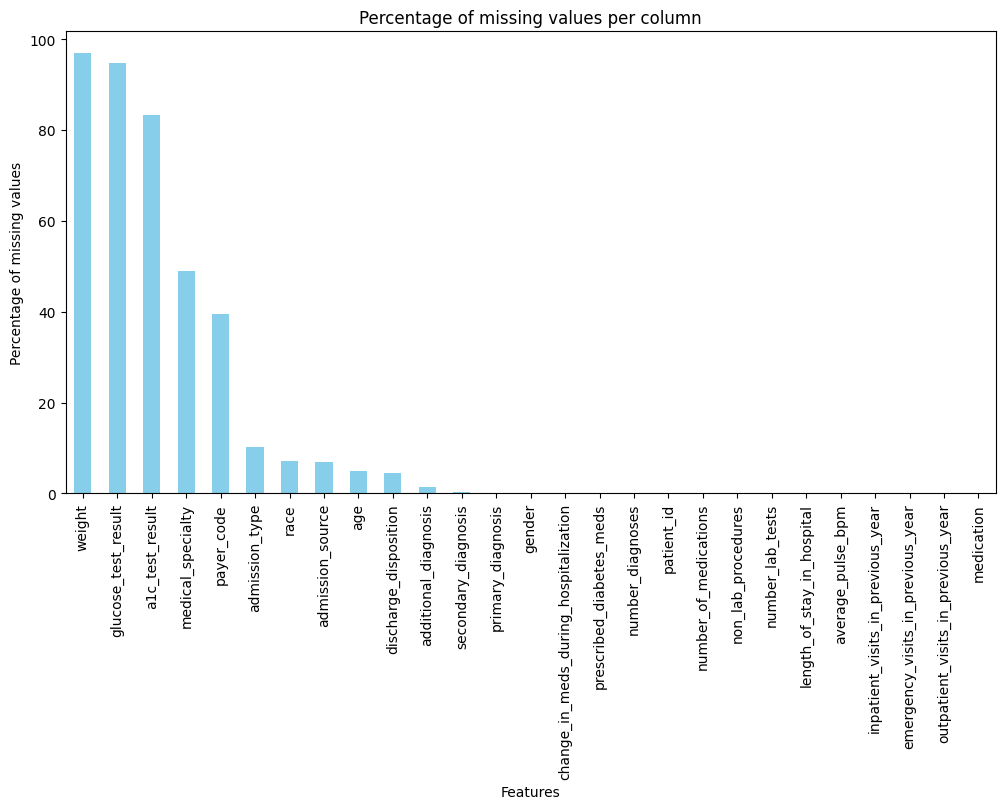

In [108]:
nan_percentage = (train.isnull().mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
nan_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of missing values per column')
plt.xlabel('Features')
plt.ylabel('Percentage of missing values')
plt.show()

### Deal with Missing values.

We are going to drop only the columns where missing values are real missing values or the ones we think that would not be much important for our model.

In [109]:
train.drop('weight', axis=1, inplace=True)
X_test.drop('weight', axis=1, inplace=True)

In [110]:
train.drop('medical_specialty', axis=1, inplace=True)
X_test.drop('medical_specialty', axis=1, inplace=True)

In glucose_test_result and in a1c_test_result the missing values are people who didn't take the test, so we replace the missing values with a new category 'Not tested'.

In [111]:
train['glucose_test_result'].fillna('Not_tested', inplace=True)
X_test['glucose_test_result'].fillna('Not_tested', inplace=True)

train['a1c_test_result'].fillna('Not_tested', inplace=True)
X_test['a1c_test_result'].fillna('Not_tested', inplace=True)

train.tail()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
660160,24531381,AfricanAmerican,Female,[80-90),MC,0,1,0,Elective,90,...,18,453,786,250,9,Not_tested,>7,Ch,Yes,"['metformin', 'glyburide', 'insulin']"
826429,4663818,AfricanAmerican,Female,[70-80),NaN,0,0,0,Urgent,98,...,9,157,197,V66,6,Not_tested,>7,Ch,Yes,"['metformin', 'glyburide']"
332030,23397147,Caucasian,Female,[60-70),NaN,0,2,2,NaN,137,...,24,428,491,276,9,>300,Not_tested,Ch,Yes,"['glyburide', 'insulin']"
757560,52161750,Caucasian,Male,[60-70),BC,0,0,2,Emergency,123,...,13,820,157,250.8,5,Not_tested,Not_tested,Ch,Yes,"['glyburide', 'insulin']"
459757,88410897,Caucasian,Male,[70-80),BC,0,0,1,Urgent,62,...,9,434,250,401,8,Not_tested,Not_tested,Ch,Yes,['insulin']


Payer Code also have some missing values but are people that don't have an insurance. <br>
We tranform the column into dummy variable: 1 if the patient have insurance, 0 if not.

In [112]:
train['payer_code'] = train['payer_code'].map(lambda x: 0 if pd.isna(x) else 1)
X_test['payer_code'] = X_test['payer_code'].map(lambda x: 0 if pd.isna(x) else 1)

In [113]:
train['payer_code']

encounter_id
533253    0
426224    0
634063    0
890610    1
654194    1
         ..
660160    1
826429    0
332030    0
757560    1
459757    1
Name: payer_code, Length: 71236, dtype: int64

For the columns age and race we decide to use imputation with the mean but instead of doing the mean for the whole column, we did for each patient. <br>
First we have to transform the age into numerical, and for that we did the mean of each interval.

In [114]:
def col_age (age):
    if not pd.isna(age):
        new_value = age.split('-')
        age_1 = int(new_value[0].strip('['))
        age_2 = int(new_value[1].strip(')'))
        return ((age_1 + age_2) / 2)
    else:
        return np.nan

train['age'] = train['age'].apply(col_age)
X_test['age'] = X_test['age'].apply(col_age)


train.head()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,70110,Caucasian,Female,75.0,0,0,0,2,Emergency,127,...,20,515,276,466,8,Not_tested,Not_tested,No,No,[]
426224,29775006,AfricanAmerican,Male,55.0,0,0,0,0,Emergency,128,...,25,38,785,162,9,Not_tested,Not_tested,No,Yes,['insulin']
634063,80729253,Caucasian,Female,65.0,0,0,0,1,NaN,94,...,22,534,135,250,6,Not_tested,Not_tested,Ch,Yes,"['glimepiride', 'insulin']"
890610,2919042,AfricanAmerican,Male,65.0,1,0,0,1,Emergency,81,...,9,569,562,455,5,Not_tested,Not_tested,No,No,[]
654194,84871971,Caucasian,Female,75.0,1,1,0,0,Elective,126,...,15,715,599,428,9,Not_tested,Not_tested,No,No,[]


In [115]:
to_drop = train[(train['admission_type'] == 'Newborn') & (train['age'] > 5)].index.to_list()
train.drop(to_drop, inplace=True)
target_binary.drop(to_drop, inplace=True)
target_multiclass.drop(to_drop, inplace=True)

Age:

In [116]:
train['age'] = train.groupby('patient_id')['age'].transform(lambda x: x.fillna(x.mean()))
train_patient_means = train.groupby('patient_id')['age'].mean()     #saving the mean age of each patient to fill the missing values in the validation set
X_test['age'] = X_test['patient_id'].map(train_patient_means).where(X_test['age'].isnull(), X_test['age'])

Race:

In [117]:
train['race'] = train.groupby('patient_id')['race'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
modes = train.groupby('patient_id')['race'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
X_test['race'] = X_test['patient_id'].map(modes).where(X_test['race'].isnull(), X_test['race'])

Now for the other numerical features we are going to do simple imputation with the mean and with the mode for the categorical.

In [118]:
numeric = train.select_dtypes(include=np.number).columns

#imputation with mean for numeric
imputer = SimpleImputer(strategy='mean')
imputer.fit(train[numeric])
train[numeric] = imputer.transform(train[numeric])
X_test[numeric] = imputer.transform(X_test[numeric])

We also tried with knn but we had worse results so we decide to go with the mean.

In [119]:
# numeric = train.select_dtypes(include=np.number).columns

# #imputation with mean for numeric
# imputer = KNNImputer(n_neighbors= 20)
# imputer.fit(train[numeric])
# train[numeric] = imputer.transform(train[numeric])
# X_test[numeric] = imputer.transform(X_test[numeric])

In [120]:
object_columns = train.select_dtypes(include=['object']).columns.tolist()
#imputation with most frequent for categorical

imp_mf = SimpleImputer(strategy='most_frequent')
imp_mf.fit(train[object_columns])
train[object_columns] = imp_mf.transform(train[object_columns])
X_test[object_columns] = imp_mf.transform(X_test[object_columns])

In [121]:
train.head()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,70110.0,Caucasian,Female,75.0,0.0,0.0,0.0,2.0,Emergency,127.0,...,20.0,515,276,466,8.0,Not_tested,Not_tested,No,No,[]
426224,29775006.0,AfricanAmerican,Male,55.0,0.0,0.0,0.0,0.0,Emergency,128.0,...,25.0,38,785,162,9.0,Not_tested,Not_tested,No,Yes,['insulin']
634063,80729253.0,Caucasian,Female,65.0,0.0,0.0,0.0,1.0,Emergency,94.0,...,22.0,534,135,250,6.0,Not_tested,Not_tested,Ch,Yes,"['glimepiride', 'insulin']"
890610,2919042.0,AfricanAmerican,Male,65.0,1.0,0.0,0.0,1.0,Emergency,81.0,...,9.0,569,562,455,5.0,Not_tested,Not_tested,No,No,[]
654194,84871971.0,Caucasian,Female,75.0,1.0,1.0,0.0,0.0,Elective,126.0,...,15.0,715,599,428,9.0,Not_tested,Not_tested,No,No,[]


### Creating some features

In [122]:
counts = train['patient_id'].value_counts()
patients_by_frequency = counts.value_counts().sort_index(ascending=False)

print(patients_by_frequency)

count
33        1
19        1
18        1
17        1
15        6
14        6
13        3
12        8
11       14
10       17
9        20
8        45
7        79
6       158
5       340
4       809
3      2013
2      7036
1     43423
Name: count, dtype: int64


In [123]:
train['hospital_visits'] = train.groupby('patient_id')['patient_id'].transform('count')
X_test['hospital_visits'] = X_test.groupby('patient_id')['patient_id'].transform('count')

In [124]:
train['Emergency_visits/total_visits'] = train['emergency_visits_in_previous_year'] / (train['inpatient_visits_in_previous_year'] + train['outpatient_visits_in_previous_year'] + train['emergency_visits_in_previous_year'])
X_test['Emergency_visits/total_visits'] = X_test['emergency_visits_in_previous_year'] / (X_test['inpatient_visits_in_previous_year'] + X_test['outpatient_visits_in_previous_year'] + X_test['emergency_visits_in_previous_year'])

In [125]:
train['Emergency_visits/total_visits'] = train['Emergency_visits/total_visits'].fillna(0)       #if total visits in previous year = 0, then the ratio is 0
X_test['Emergency_visits/total_visits'] = X_test['Emergency_visits/total_visits'].fillna(0)

In [126]:
train['n_medications/lenght_of_stay'] = train['number_of_medications'] / train['length_of_stay_in_hospital']
X_test['n_medications/lenght_of_stay'] = X_test['number_of_medications'] / X_test['length_of_stay_in_hospital']

In [127]:
train

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,...,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,hospital_visits,Emergency_visits/total_visits,n_medications/lenght_of_stay
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,70110.0,Caucasian,Female,75.0,0.0,0.0,0.0,2.0,Emergency,127.0,...,466,8.0,Not_tested,Not_tested,No,No,[],6,0.0,10.000000
426224,29775006.0,AfricanAmerican,Male,55.0,0.0,0.0,0.0,0.0,Emergency,128.0,...,162,9.0,Not_tested,Not_tested,No,Yes,['insulin'],1,0.0,1.785714
634063,80729253.0,Caucasian,Female,65.0,0.0,0.0,0.0,1.0,Emergency,94.0,...,250,6.0,Not_tested,Not_tested,Ch,Yes,"['glimepiride', 'insulin']",1,0.0,3.666667
890610,2919042.0,AfricanAmerican,Male,65.0,1.0,0.0,0.0,1.0,Emergency,81.0,...,455,5.0,Not_tested,Not_tested,No,No,[],1,0.0,1.500000
654194,84871971.0,Caucasian,Female,75.0,1.0,1.0,0.0,0.0,Elective,126.0,...,428,9.0,Not_tested,Not_tested,No,No,[],2,0.0,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660160,24531381.0,AfricanAmerican,Female,85.0,1.0,0.0,1.0,0.0,Elective,90.0,...,250,9.0,Not_tested,>7,Ch,Yes,"['metformin', 'glyburide', 'insulin']",1,1.0,2.571429
826429,4663818.0,AfricanAmerican,Female,75.0,0.0,0.0,0.0,0.0,Urgent,98.0,...,V66,6.0,Not_tested,>7,Ch,Yes,"['metformin', 'glyburide']",1,0.0,1.000000
332030,23397147.0,Caucasian,Female,65.0,0.0,0.0,2.0,2.0,Emergency,137.0,...,276,9.0,>300,Not_tested,Ch,Yes,"['glyburide', 'insulin']",4,0.5,4.800000


### Transforming Categorical into Numerical

For the medication column we did Dummy variable for each nedication.

In [128]:
m = []
for i in train['medication']:
    a = i.strip('[]').split(',')
    if len(a)  == 1:
        m.append(a[0].strip(" '"))
    elif len(a) > 1:
        for j in a:
            m.append(j.strip(" '"))
p = set(m)
p.remove('')
print (len(p), 'different medications.')
list(p)

21 different medications.


['miglitol',
 'acetohexamide',
 'glipizide-metformin',
 'glipizide',
 'metformin',
 'glyburide-metformin',
 'acarbose',
 'nateglinide',
 'tolbutamide',
 'insulin',
 'glimepiride',
 'repaglinide',
 'metformin-rosiglitazone',
 'pioglitazone',
 'glyburide',
 'chlorpropamide',
 'metformin-pioglitazone',
 'rosiglitazone',
 'tolazamide',
 'glimepiride-pioglitazone',
 'troglitazone']

In [129]:
for i in list(p):
    train['meds_'+ i] = train['medication'].apply(lambda x: 1 if i in x else 0)
    X_test['meds_'+ i] = X_test['medication'].apply(lambda x: 1 if i in x else 0)
    
train.drop('medication', axis=1, inplace=True)
X_test.drop('medication', axis=1, inplace=True)

train.head()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,...,meds_repaglinide,meds_metformin-rosiglitazone,meds_pioglitazone,meds_glyburide,meds_chlorpropamide,meds_metformin-pioglitazone,meds_rosiglitazone,meds_tolazamide,meds_glimepiride-pioglitazone,meds_troglitazone
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,70110.0,Caucasian,Female,75.0,0.0,0.0,0.0,2.0,Emergency,127.0,...,0,0,0,0,0,0,0,0,0,0
426224,29775006.0,AfricanAmerican,Male,55.0,0.0,0.0,0.0,0.0,Emergency,128.0,...,0,0,0,0,0,0,0,0,0,0
634063,80729253.0,Caucasian,Female,65.0,0.0,0.0,0.0,1.0,Emergency,94.0,...,0,0,0,0,0,0,0,0,0,0
890610,2919042.0,AfricanAmerican,Male,65.0,1.0,0.0,0.0,1.0,Emergency,81.0,...,0,0,0,0,0,0,0,0,0,0
654194,84871971.0,Caucasian,Female,75.0,1.0,1.0,0.0,0.0,Elective,126.0,...,0,0,0,0,0,0,0,0,0,0


For the diagnosis we transform all the codes into categories based on https://en.wikipedia.org/wiki/List_of_ICD-9_codes. 

In [130]:
def icd9_to_category (icd9):
    if not pd.isna(icd9):
        if icd9[0] == 'E' or icd9[0] == 'V':
            return 'other health factors and external causes'
        else:
            icd9 = float(icd9)
            if icd9 >= 1 and icd9 <= 139:
                return 'infectious and parasitic diseases'
            elif icd9 >= 140 and icd9 <= 239:
                return 'neoplasms'
            elif icd9 >= 240 and icd9 <= 279:
                return 'diabetes,  endocrine and metabolic disorders'
            elif icd9 >= 280 and icd9 <= 289:
                return 'other diseases/conditions'
            elif icd9 >= 290 and icd9 <= 319:
                return 'mental disorders'
            elif icd9 >= 320 and icd9 <= 389:
                return 'other diseases/conditions'
            elif icd9 >= 390 and icd9 <= 459:
                return 'circulatory system diseases'
            elif icd9 >= 460 and icd9 <= 519:
                return 'respiratory system diseases'
            elif icd9 >= 520 and icd9 <= 579:
                return 'digestive system diseases'
            elif icd9 >= 580 and icd9 <= 629:
                return 'genitourinary system diseases'
            elif icd9 >= 630 and icd9 <= 679:
                return 'other diseases/conditions'
            elif icd9 >= 680 and icd9 <= 709:
                return 'skin diseases'
            elif icd9 >= 710 and icd9 <= 739:
                return 'musculoskeletal disorders'
            elif icd9 >= 740 and icd9 <= 759:
                return 'other diseases/conditions'
            elif icd9 >= 760 and icd9 <= 779:
                return 'perinatal conditions'
            elif icd9 >= 780 and icd9 <= 799:
                return 'uncertain conditions'
            elif icd9 >= 800 and icd9 <= 999:
                return 'injury and poisoning'
            elif icd9 == 0:
                return 'None'
    else:
        return np.nan

In [131]:
train['primary_diagnosis'] = train['primary_diagnosis'].apply(icd9_to_category)
X_test['primary_diagnosis'] = X_test['primary_diagnosis'].apply(icd9_to_category)

train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(icd9_to_category)
X_test['secondary_diagnosis'] = X_test['secondary_diagnosis'].apply(icd9_to_category)

train['additional_diagnosis'] = train['additional_diagnosis'].apply(icd9_to_category)
X_test['additional_diagnosis'] = X_test['additional_diagnosis'].apply(icd9_to_category)

train.head()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,...,meds_repaglinide,meds_metformin-rosiglitazone,meds_pioglitazone,meds_glyburide,meds_chlorpropamide,meds_metformin-pioglitazone,meds_rosiglitazone,meds_tolazamide,meds_glimepiride-pioglitazone,meds_troglitazone
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,70110.0,Caucasian,Female,75.0,0.0,0.0,0.0,2.0,Emergency,127.0,...,0,0,0,0,0,0,0,0,0,0
426224,29775006.0,AfricanAmerican,Male,55.0,0.0,0.0,0.0,0.0,Emergency,128.0,...,0,0,0,0,0,0,0,0,0,0
634063,80729253.0,Caucasian,Female,65.0,0.0,0.0,0.0,1.0,Emergency,94.0,...,0,0,0,0,0,0,0,0,0,0
890610,2919042.0,AfricanAmerican,Male,65.0,1.0,0.0,0.0,1.0,Emergency,81.0,...,0,0,0,0,0,0,0,0,0,0
654194,84871971.0,Caucasian,Female,75.0,1.0,1.0,0.0,0.0,Elective,126.0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
diagnosis_values = train['primary_diagnosis'].unique().tolist() + train['secondary_diagnosis'].unique().tolist() + train['additional_diagnosis'].unique().tolist()

In [133]:
diagnosis_values = list(set(diagnosis_values))

In [134]:
for i in diagnosis_values:
    train['diagnosis_' + i] = (train['primary_diagnosis'].str.contains(i) | train['secondary_diagnosis'].str.contains(i) | train['additional_diagnosis'].str.contains(i)).astype(int)
train.drop(['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], axis=1, inplace=True)

for i in diagnosis_values:
    X_test['diagnosis_' + i] = (X_test['primary_diagnosis'].str.contains(i) | X_test['secondary_diagnosis'].str.contains(i) | X_test['additional_diagnosis'].str.contains(i)).astype(int)
X_test.drop(['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], axis=1, inplace=True)

In [135]:
train.head()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,...,diagnosis_respiratory system diseases,diagnosis_circulatory system diseases,diagnosis_genitourinary system diseases,diagnosis_infectious and parasitic diseases,diagnosis_musculoskeletal disorders,diagnosis_injury and poisoning,diagnosis_digestive system diseases,diagnosis_uncertain conditions,diagnosis_mental disorders,diagnosis_neoplasms
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,70110.0,Caucasian,Female,75.0,0.0,0.0,0.0,2.0,Emergency,127.0,...,1,0,0,0,0,0,0,0,0,0
426224,29775006.0,AfricanAmerican,Male,55.0,0.0,0.0,0.0,0.0,Emergency,128.0,...,0,0,0,1,0,0,0,1,0,1
634063,80729253.0,Caucasian,Female,65.0,0.0,0.0,0.0,1.0,Emergency,94.0,...,0,0,0,1,0,0,1,0,0,0
890610,2919042.0,AfricanAmerican,Male,65.0,1.0,0.0,0.0,1.0,Emergency,81.0,...,0,1,0,0,0,0,1,0,0,0
654194,84871971.0,Caucasian,Female,75.0,1.0,1.0,0.0,0.0,Elective,126.0,...,0,1,1,0,1,0,0,0,0,0


For the binary features we applied label encoding with 1 and 0.

In [136]:
binary_columns = [i for i in unique_values if unique_values[i] == 2]
binary_columns

['gender', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds']

In [137]:
train['gender'] = train['gender'].map ({'Male': 0, 'Female': 1})
X_test['gender'] = X_test['gender'].map ({'Male': 0, 'Female': 1})

In [138]:
train['change_in_meds_during_hospitalization'] = train['change_in_meds_during_hospitalization'].map({'No': 0, 'Ch': 1})
X_test['change_in_meds_during_hospitalization'] = X_test['change_in_meds_during_hospitalization'].map({'No': 0, 'Ch': 1})

In [139]:
train['prescribed_diabetes_meds'] = train['prescribed_diabetes_meds'].map({'No': 0, 'Yes': 1})
X_test['prescribed_diabetes_meds'] = X_test['prescribed_diabetes_meds'].map({'No': 0, 'Yes': 1})

In [140]:
train[['change_in_meds_during_hospitalization' ,'prescribed_diabetes_meds', 'gender']]

,change_in_meds_during_hospitalization,prescribed_diabetes_meds,gender
encounter_id,,,
533253,0,0,1
426224,0,1,0
634063,1,1,1
890610,0,0,0
654194,0,0,1
...,...,...,...
660160,1,1,1
826429,1,1,1
332030,1,1,1


In [141]:
target_binary = target_binary.map({'No': 0, 'Yes': 1})

In [142]:
target_binary

encounter_id
533253    0
426224    0
634063    0
890610    0
654194    0
         ..
660160    0
826429    0
332030    1
757560    0
459757    0
Name: readmitted_binary, Length: 71231, dtype: int64

We also applied label encoding for other categorical features.

In [143]:
train['admission_type'].unique()

array(['Emergency', 'Elective', 'Urgent', 'Trauma Center', 'Newborn'],
      dtype=object)

In [144]:
#Doing label encoding with the order of emergency in this site: https://resdac.org/cms-data/variables/admission-type-code
train['admission_type'] = train['admission_type'].map({'Emergency': 1, 'Urgent': 2, 'Elective': 3, 'Newborn': 4, 'Trauma Center': 5})
X_test['admission_type'] = X_test['admission_type'].map({'Emergency': 1, 'Urgent': 2, 'Elective': 3, 'Newborn': 4, 'Trauma Center': 5})

In [145]:
train['admission_type'].unique()

array([1, 3, 2, 5, 4], dtype=int64)

In [146]:
train['admission_source'].value_counts()

admission_source
Emergency Room                                               45231
Physician Referral                                           20677
Transfer from a hospital                                      2227
Transfer from another health care facility                    1562
Clinic Referral                                                779
Transfer from a Skilled Nursing Facility (SNF)                 595
HMO Referral                                                   129
Court/Law Enforcement                                           11
Transfer from hospital inpt/same fac reslt in a sep claim        8
Transfer from critial access hospital                            7
Transfer from Ambulatory Surgery Center                          2
Extramural Birth                                                 1
Normal Delivery                                                  1
Sick Baby                                                        1
Name: count, dtype: int64

In [147]:
train['admission_source'] = train['admission_source'].map(lambda x: 'Transfer from Another Health Facility' if 'Transfer' in x else x)
X_test['admission_source'] = X_test['admission_source'].map(lambda x: 'Transfer from Another Health Facility' if 'Transfer' in x else x)

train['admission_source'].unique()

array(['Emergency Room', 'Clinic Referral',
       'Transfer from Another Health Facility', 'Physician Referral',
       'HMO Referral', 'Court/Law Enforcement', 'Extramural Birth',
       'Normal Delivery', 'Sick Baby'], dtype=object)

In [148]:
obj_cols = train.select_dtypes(include=['object']).columns.tolist()
obj_cols

['race',
 'discharge_disposition',
 'admission_source',
 'glucose_test_result',
 'a1c_test_result']

For the rest of the categorical we are applying one hot encoding.

In [149]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded_bm = encoder.fit_transform(train[obj_cols])
X_test_encoded_bm = encoder.transform(X_test[obj_cols])

encoded_columns = encoder.get_feature_names_out(obj_cols)

X_train_encoded_bm_df = pd.DataFrame(X_train_encoded_bm, columns=encoded_columns, index=train[obj_cols].index)
X_test_encoded_bm_df = pd.DataFrame(X_test_encoded_bm, columns=encoded_columns, index=X_test[obj_cols].index)

X_train_num = train.drop(obj_cols, axis=1)
X_test_num = X_test.drop(obj_cols, axis=1)

train = pd.concat([X_train_num, X_train_encoded_bm_df], axis=1)
X_test = pd.concat([X_test_num, X_test_encoded_bm_df], axis=1)


c:\Users\manab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


We will not need the patient_id anymore so we drop it.

In [150]:
train.drop('patient_id', axis=1, inplace=True)
X_test.drop('patient_id', axis=1, inplace=True)

### Outliers

In [151]:
numerical = train.select_dtypes(include=np.number).columns.tolist()
cat = {}
for i in numerical:
    cat[i] =  train[i].nunique()

In [152]:
#get cat keys that values = 2
non_binary = [i for i in cat if cat[i] != 2]
non_binary

binary = [i for i in cat if cat[i] == 2]
binary

['gender',
 'payer_code',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'meds_miglitol',
 'meds_acetohexamide',
 'meds_glipizide-metformin',
 'meds_glipizide',
 'meds_metformin',
 'meds_glyburide-metformin',
 'meds_acarbose',
 'meds_nateglinide',
 'meds_tolbutamide',
 'meds_insulin',
 'meds_glimepiride',
 'meds_repaglinide',
 'meds_metformin-rosiglitazone',
 'meds_pioglitazone',
 'meds_glyburide',
 'meds_chlorpropamide',
 'meds_metformin-pioglitazone',
 'meds_rosiglitazone',
 'meds_tolazamide',
 'meds_glimepiride-pioglitazone',
 'meds_troglitazone',
 'diagnosis_skin diseases',
 'diagnosis_other diseases/conditions',
 'diagnosis_other health factors and external causes',
 'diagnosis_diabetes,  endocrine and metabolic disorders',
 'diagnosis_respiratory system diseases',
 'diagnosis_circulatory system diseases',
 'diagnosis_genitourinary system diseases',
 'diagnosis_infectious and parasitic diseases',
 'diagnosis_musculoskeletal disorders',
 'diagnosis_injury a

In [153]:
non_binary

['age',
 'outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'admission_type',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses',
 'hospital_visits',
 'Emergency_visits/total_visits',
 'n_medications/lenght_of_stay']

In [154]:
train.head()

,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,...,admission_source_Sick Baby,admission_source_Transfer from Another Health Facility,glucose_test_result_>200,glucose_test_result_>300,glucose_test_result_Norm,glucose_test_result_Not_tested,a1c_test_result_>7,a1c_test_result_>8,a1c_test_result_Norm,a1c_test_result_Not_tested
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,1,75.0,0.0,0.0,0.0,2.0,1,127.0,2.0,48.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
426224,0,55.0,0.0,0.0,0.0,0.0,1,128.0,14.0,71.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
634063,1,65.0,0.0,0.0,0.0,1.0,1,94.0,6.0,60.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
890610,0,65.0,1.0,0.0,0.0,1.0,1,81.0,6.0,48.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
654194,1,75.0,1.0,1.0,0.0,0.0,3,126.0,6.0,47.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


<Figure size 1200x2400 with 0 Axes>

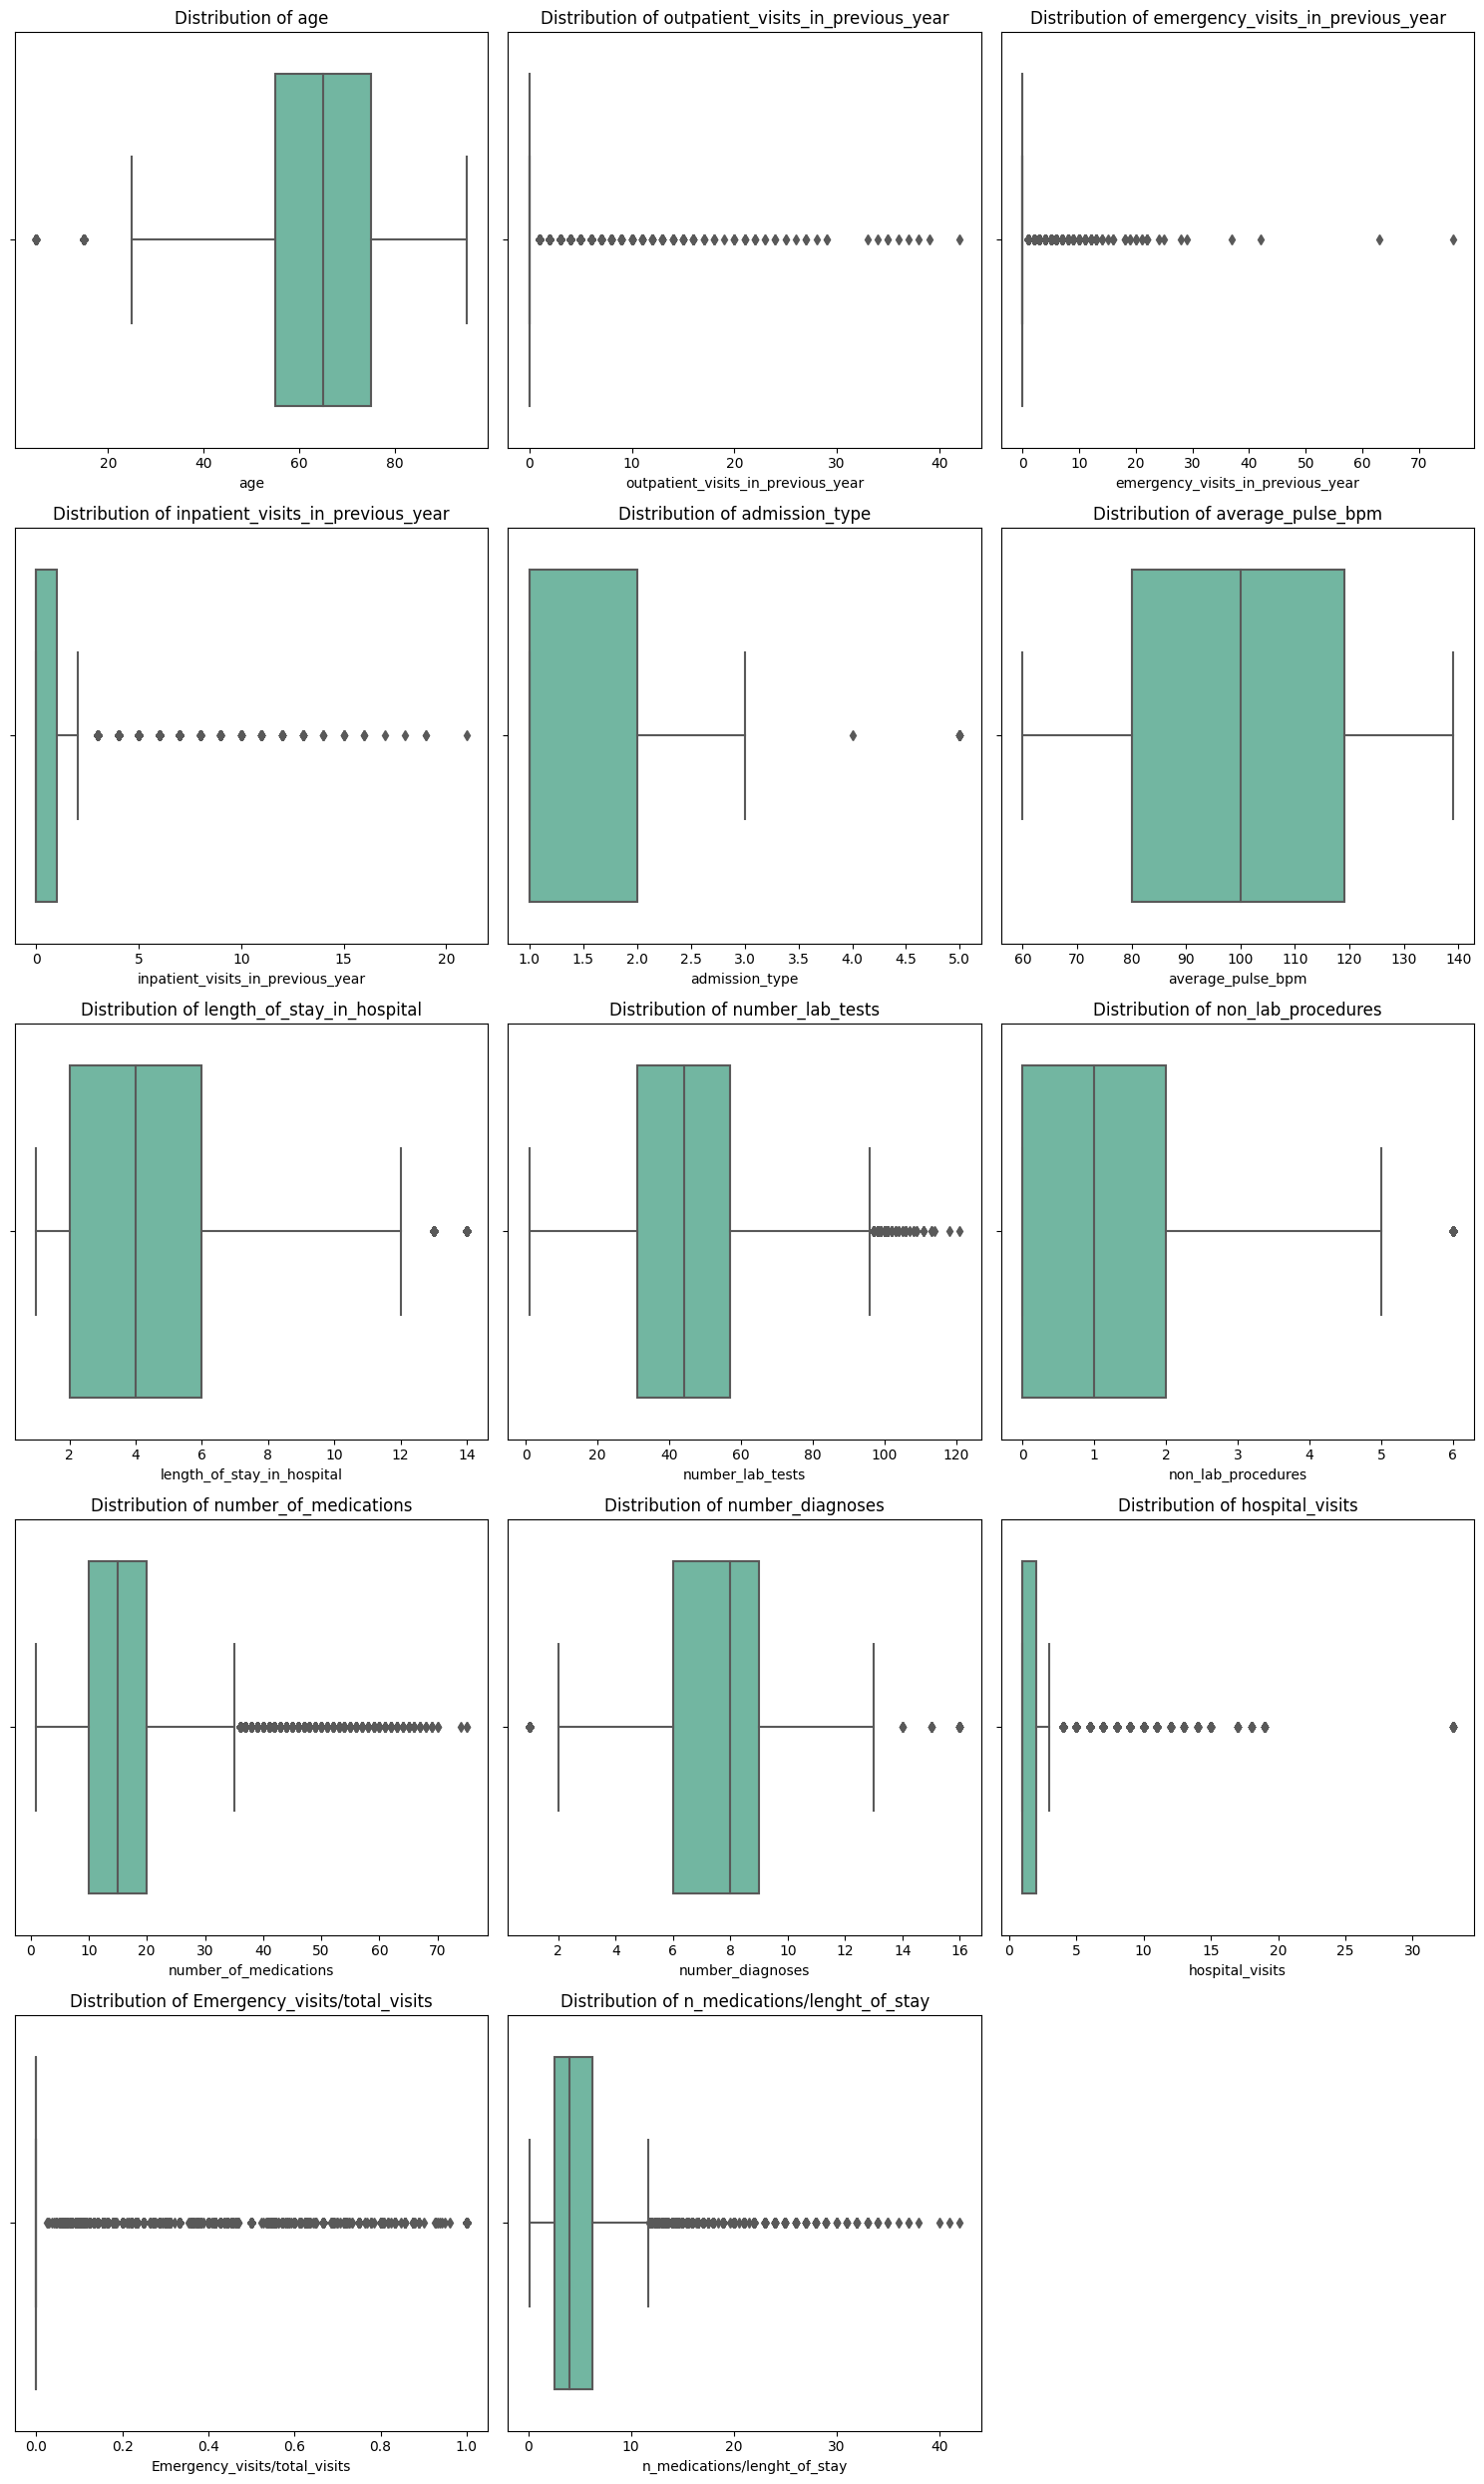

In [155]:
plt.figure(figsize=(12, 24))

num_plots = len(non_binary)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i in range(len(non_binary), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

for i, col in enumerate(non_binary):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data = train, x=train[col], orient='h', palette='Set2')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


### Scaling the data

In [156]:
scaler = RobustScaler()
train.loc[:, non_binary] = scaler.fit_transform(train[non_binary])
X_test.loc[:, non_binary] = scaler.transform(X_test[non_binary])

### Feature Selection

Variance

In [157]:
var = train.var()

In [158]:
for i in var:
    if i == 0:
        print(i)

We don't have invariate features.

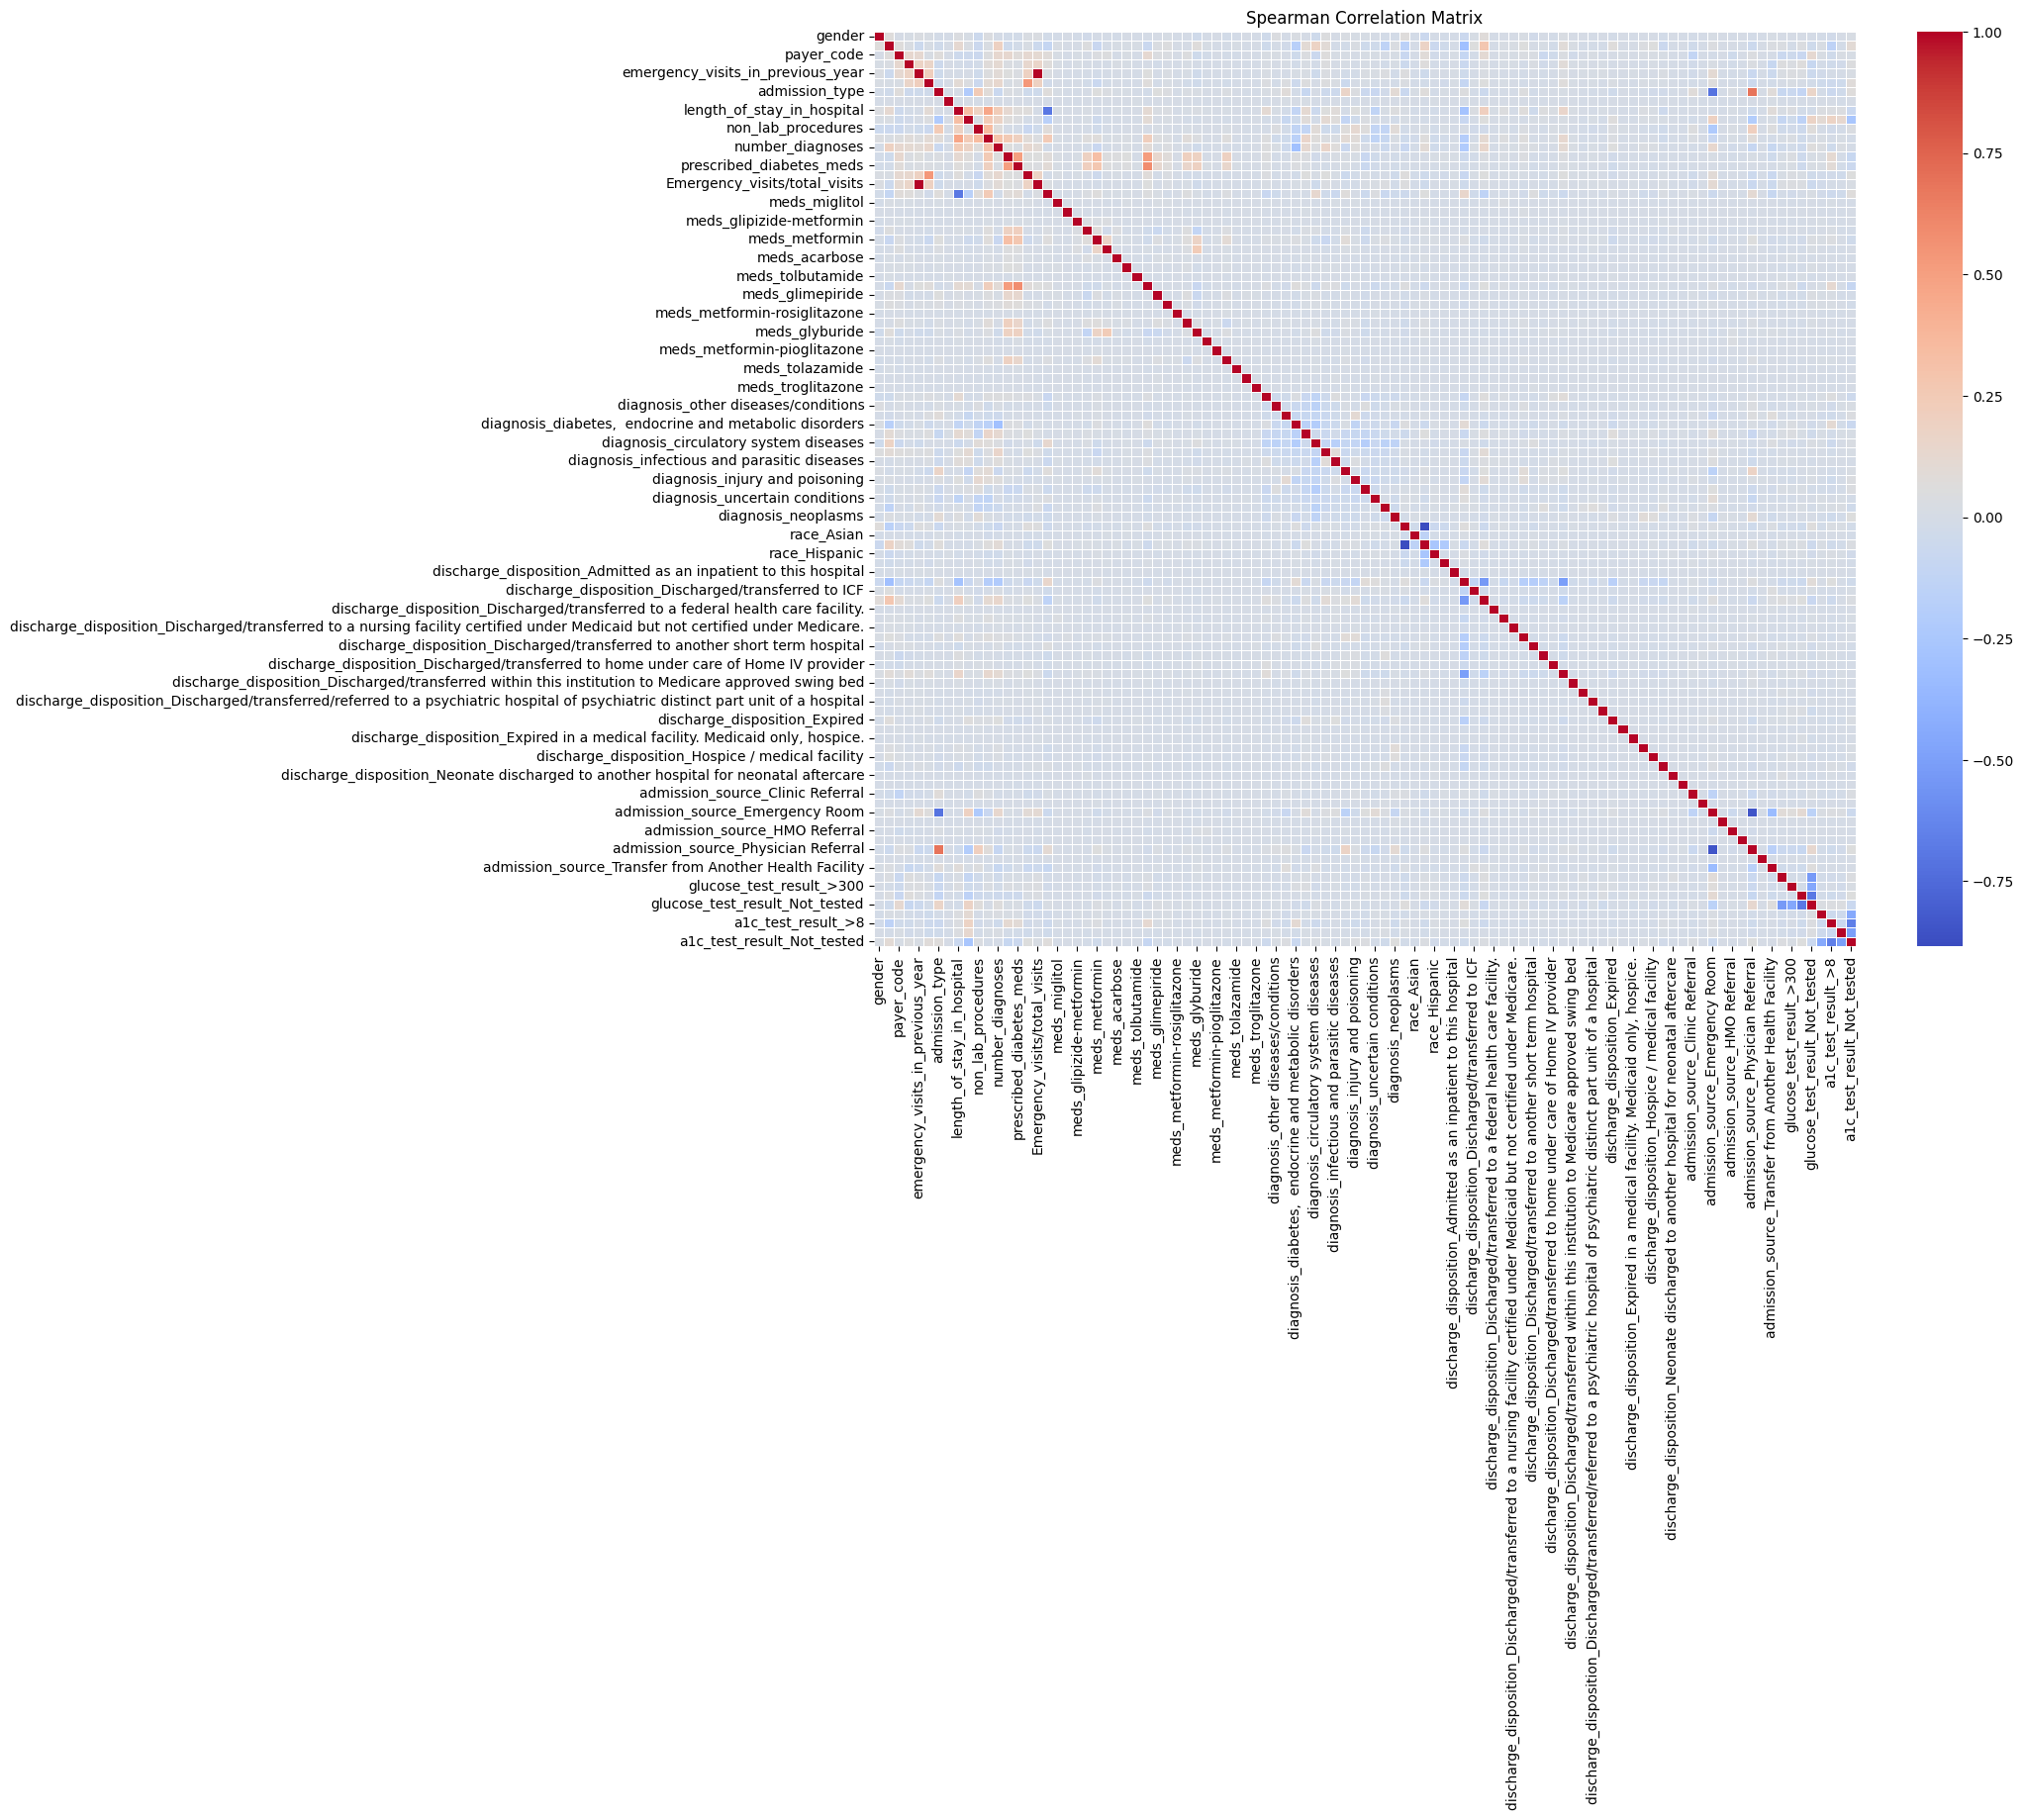

In [159]:
correlation_matrix = train.corr(method='spearman')
corr_cols = []
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()


In [160]:
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and abs(correlation_matrix.loc[i,j]) > 0.8:
            corr_cols.append(i)
            corr_cols.append(j)
corr_cols = list(set(corr_cols))
corr_cols

['Emergency_visits/total_visits',
 'race_AfricanAmerican',
 'admission_source_Physician Referral',
 'race_Caucasian',
 'emergency_visits_in_previous_year',
 'admission_source_Emergency Room']

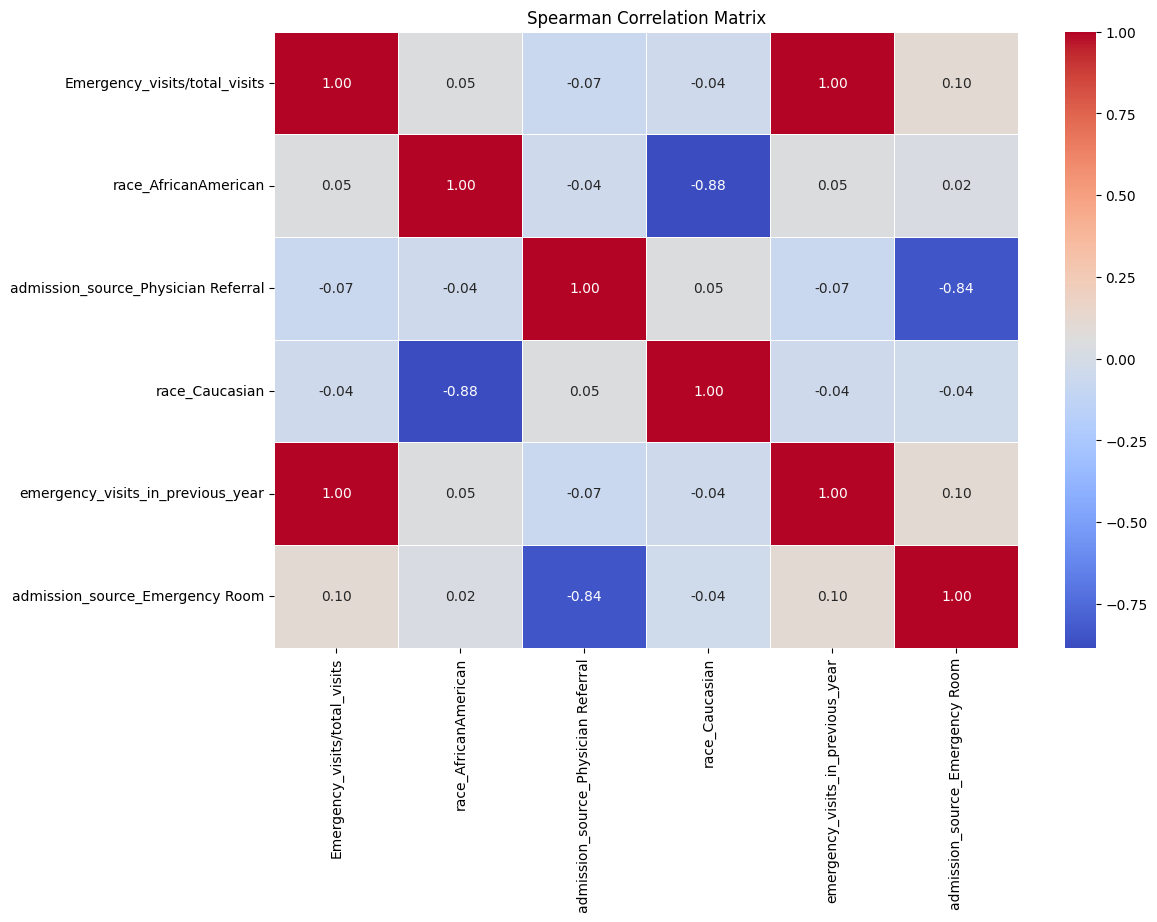

In [161]:
correlation_matrix = train[corr_cols].corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True,fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()

Emergency visits in previous year and emergency visits in previous year/total_visits are 100% correlated so they can't be both in the model. Let's see if other fs methods say to drop one of them.

3. Feature Importance com Random Forest

In [162]:
rf_model  = RandomForestClassifier(class_weight='balanced', random_state=42,max_depth=6, n_jobs=-1)


rf_model.fit(train, target_binary)
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [163]:
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

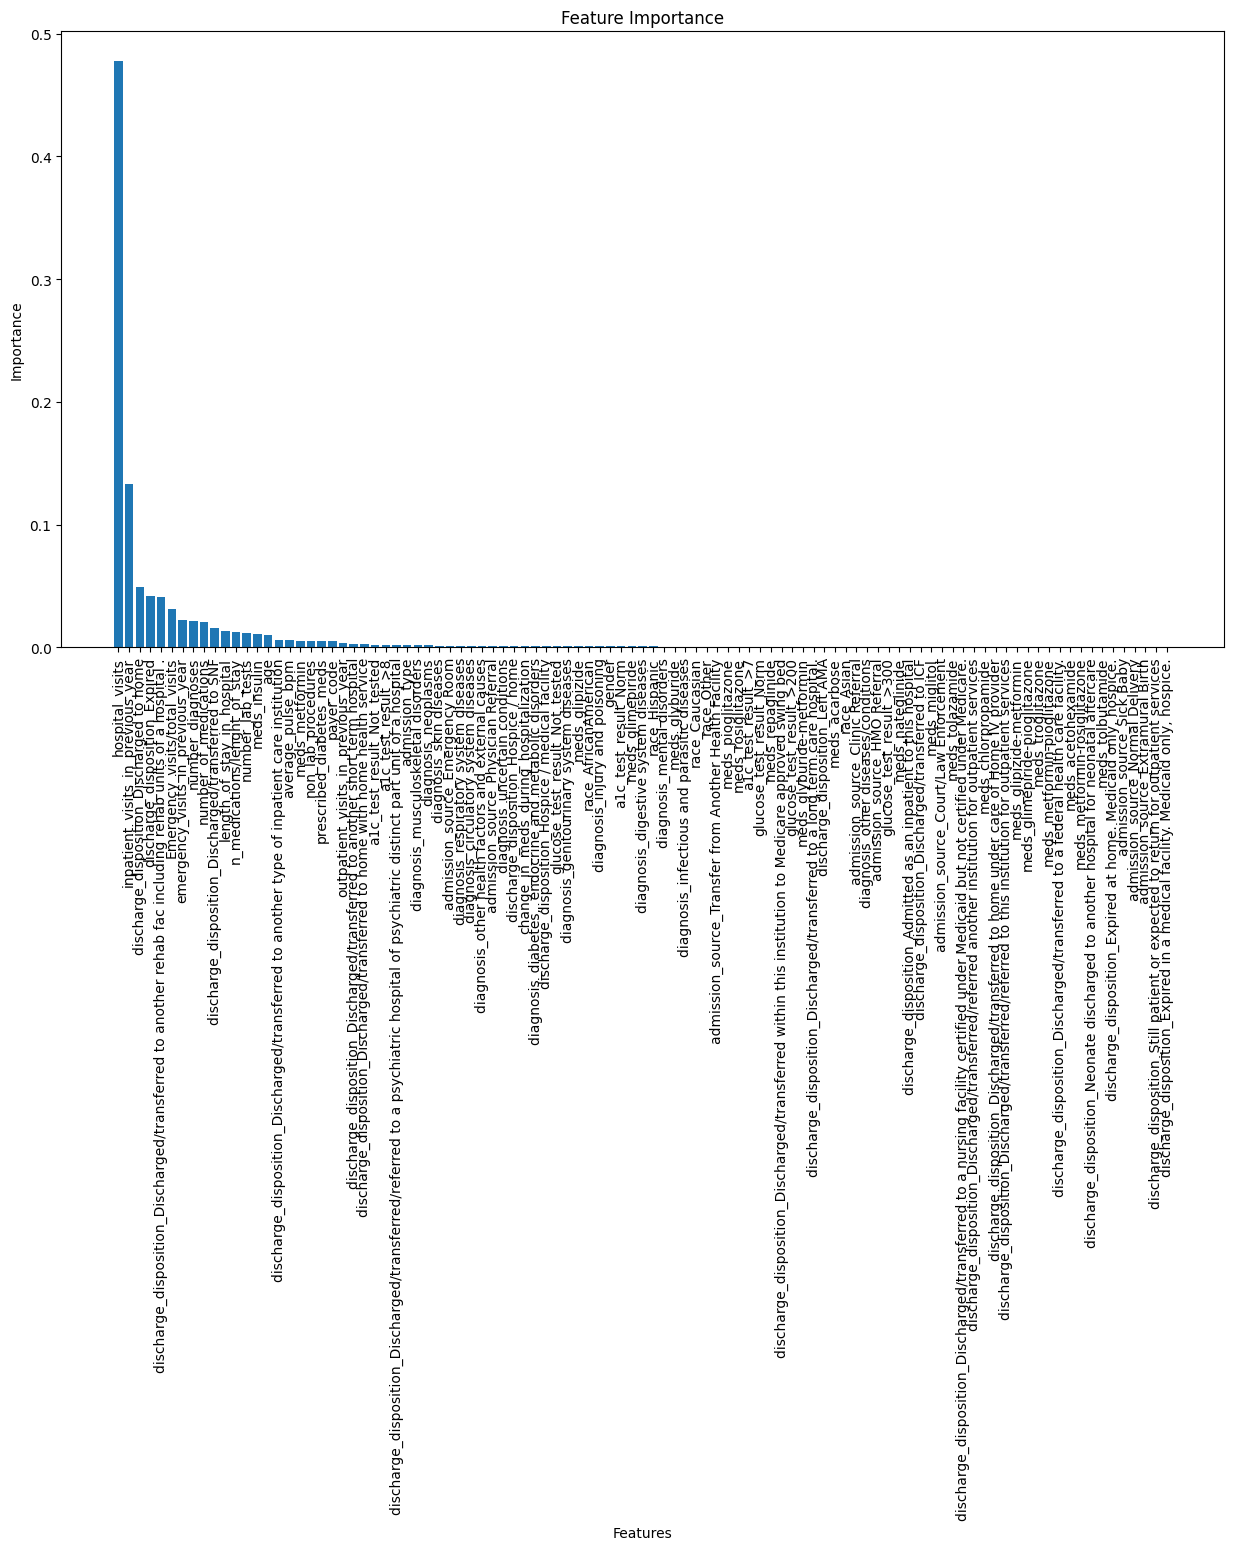

In [164]:
plt.figure(figsize=(15, 8))
plt.bar(range(len(feature_importance_df)), feature_importance_df['Importance'], align='center')
plt.xticks(range(len(feature_importance_df)), feature_importance_df['Feature'], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

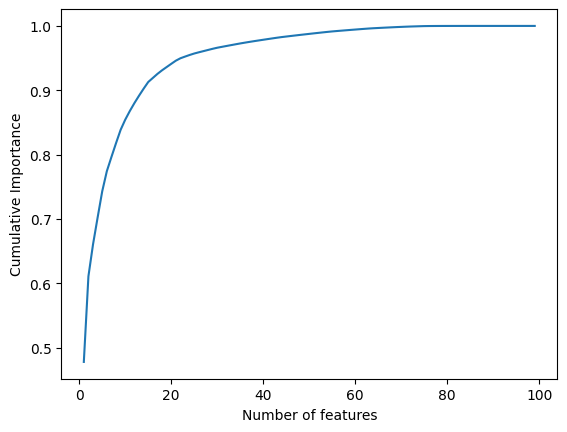

In [165]:
sorted_indices = np.argsort(feature_importances)[::-1]
cumulative_importance = np.cumsum(feature_importances[sorted_indices])

plt.plot(range(1, len(feature_importances) + 1), cumulative_importance)
plt.xlabel('Number of features')
plt.ylabel('Cumulative Importance')
plt.show()

Number of features: 80

In [166]:
top_80_features = sorted_indices[:80]
selected_features = train.columns[top_80_features]

In [167]:
selected = {}
for i in selected_features:
    selected[i] = 1

RFE with Random forest

In [168]:
rf_classifier = RandomForestClassifier(class_weight='balanced', n_jobs = -1, random_state=42, max_depth=6)

rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='f1')

rfecv.fit(train, target_binary)

optimal_n_features = rfecv.n_features_
print(f"Ideal number of features: {optimal_n_features}")


Ideal number of features: 2


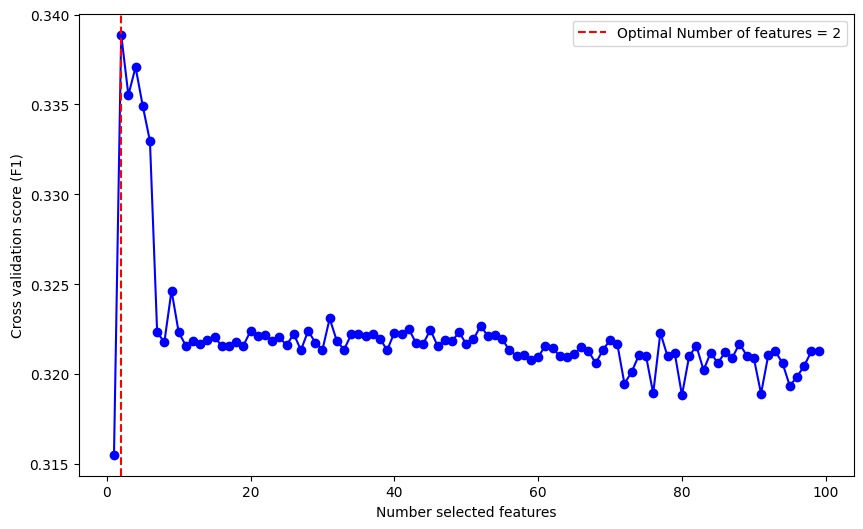

In [169]:
plt.figure(figsize=(10, 6))
plt.xlabel("Number selected features")
plt.ylabel("Cross validation score (F1)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o', linestyle='-', color='b')
plt.axvline(optimal_n_features, color='r', linestyle='--', label=f'Optimal Number of features = {optimal_n_features}')
plt.legend()
plt.show()

In [170]:
selected_features_mask = rfecv.support_
selected_features = train.columns[selected_features_mask]

print("Selected features:")
print(selected_features)

Selected features:
Index(['inpatient_visits_in_previous_year', 'hospital_visits'], dtype='object')


In [171]:
for i in selected_features:
    if i in selected.keys():
        selected[i] += 1
    else:
        selected[i] = 1

In [172]:
selected

{'hospital_visits': 2,
 'inpatient_visits_in_previous_year': 2,
 'discharge_disposition_Discharged to home': 1,
 'discharge_disposition_Expired': 1,
 'discharge_disposition_Discharged/transferred to another rehab fac including rehab units of a hospital .': 1,
 'Emergency_visits/total_visits': 1,
 'emergency_visits_in_previous_year': 1,
 'number_diagnoses': 1,
 'number_of_medications': 1,
 'discharge_disposition_Discharged/transferred to SNF': 1,
 'length_of_stay_in_hospital': 1,
 'n_medications/lenght_of_stay': 1,
 'number_lab_tests': 1,
 'meds_insulin': 1,
 'age': 1,
 'discharge_disposition_Discharged/transferred to another type of inpatient care institution': 1,
 'average_pulse_bpm': 1,
 'meds_metformin': 1,
 'non_lab_procedures': 1,
 'prescribed_diabetes_meds': 1,
 'payer_code': 1,
 'outpatient_visits_in_previous_year': 1,
 'discharge_disposition_Discharged/transferred to another short term hospital': 1,
 'discharge_disposition_Discharged/transferred to home with home health service

Lasso

In [173]:
reg = LassoCV().fit(train, target_binary)
coef = pd.Series(reg.coef_, index = train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 51 variables and eliminated the other 48 variables


In [174]:
coef.sort_values()

discharge_disposition_Expired                                                                                                     -0.108702
discharge_disposition_Hospice / home                                                                                              -0.052451
discharge_disposition_Hospice / medical facility                                                                                  -0.031645
discharge_disposition_Discharged/transferred to a long term care hospital.                                                        -0.028175
payer_code                                                                                                                        -0.026301
                                                                                                                                     ...   
hospital_visits                                                                                                                    0.034696
discharge_dispositio

In [175]:
lasso_features = coef[coef != 0].index.tolist()

In [176]:
lasso_features

['gender',
 'age',
 'payer_code',
 'outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'admission_type',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'hospital_visits',
 'Emergency_visits/total_visits',
 'n_medications/lenght_of_stay',
 'meds_glipizide',
 'meds_metformin',
 'meds_insulin',
 'meds_glimepiride',
 'meds_glyburide',
 'meds_rosiglitazone',
 'diagnosis_skin diseases',
 'diagnosis_other diseases/conditions',
 'diagnosis_other health factors and external causes',
 'diagnosis_diabetes,  endocrine and metabolic disorders',
 'diagnosis_respiratory system diseases',
 'diagnosis_circulatory system diseases',
 'diagnosis_genitourinary system diseases',
 'diagnosis_musculoskeletal disorders',
 'diagnosis_injury and poisoning',
 'diagnosis_digestive system diseases',
 'diagnos

In [177]:
for i in lasso_features:
    if i in selected.keys():
        selected[i] += 1
    else:
        selected[i] = 1

In [178]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(10,12))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

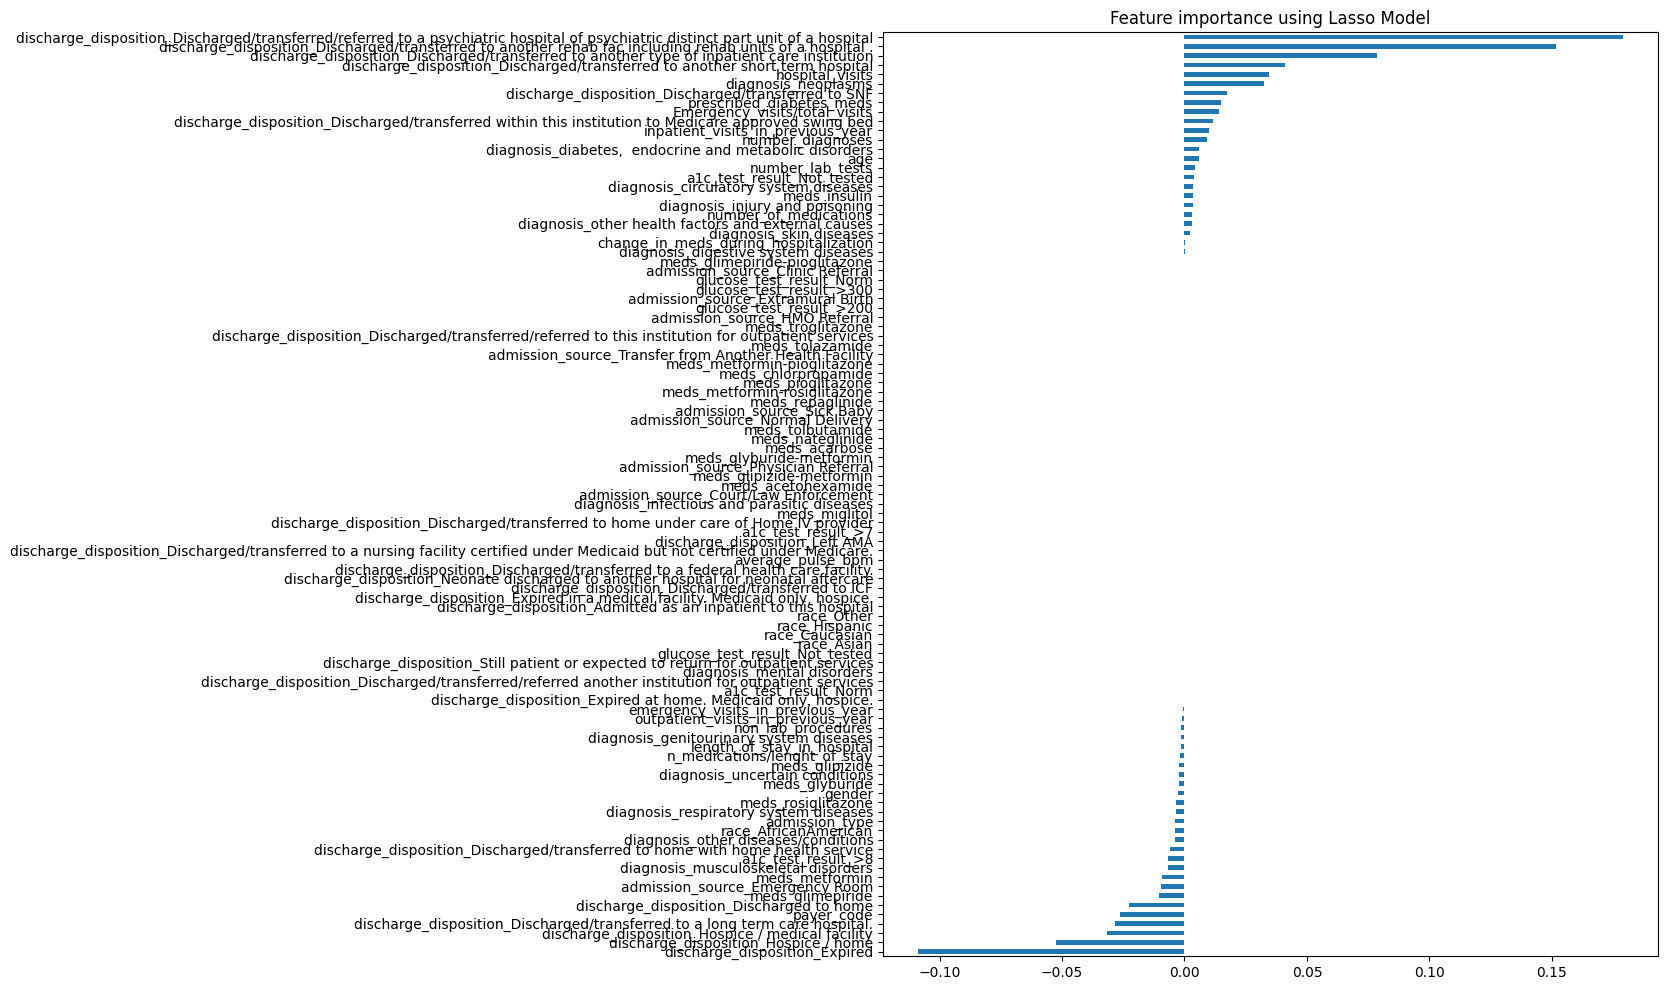

In [179]:
plot_importance(coef,'Lasso')

### Final Decision:

In [180]:
selected

{'hospital_visits': 3,
 'inpatient_visits_in_previous_year': 3,
 'discharge_disposition_Discharged to home': 2,
 'discharge_disposition_Expired': 2,
 'discharge_disposition_Discharged/transferred to another rehab fac including rehab units of a hospital .': 2,
 'Emergency_visits/total_visits': 2,
 'emergency_visits_in_previous_year': 2,
 'number_diagnoses': 2,
 'number_of_medications': 2,
 'discharge_disposition_Discharged/transferred to SNF': 2,
 'length_of_stay_in_hospital': 2,
 'n_medications/lenght_of_stay': 2,
 'number_lab_tests': 2,
 'meds_insulin': 2,
 'age': 2,
 'discharge_disposition_Discharged/transferred to another type of inpatient care institution': 2,
 'average_pulse_bpm': 1,
 'meds_metformin': 2,
 'non_lab_procedures': 2,
 'prescribed_diabetes_meds': 2,
 'payer_code': 2,
 'outpatient_visits_in_previous_year': 2,
 'discharge_disposition_Discharged/transferred to another short term hospital': 2,
 'discharge_disposition_Discharged/transferred to home with home health service

Since emergency visits in previous year only have 1 vote we are not going to have correlated features.

In [181]:
keep = []
for i in selected.keys():
    if selected[i] >= 2:
        keep.append(i)
keep

['hospital_visits',
 'inpatient_visits_in_previous_year',
 'discharge_disposition_Discharged to home',
 'discharge_disposition_Expired',
 'discharge_disposition_Discharged/transferred to another rehab fac including rehab units of a hospital .',
 'Emergency_visits/total_visits',
 'emergency_visits_in_previous_year',
 'number_diagnoses',
 'number_of_medications',
 'discharge_disposition_Discharged/transferred to SNF',
 'length_of_stay_in_hospital',
 'n_medications/lenght_of_stay',
 'number_lab_tests',
 'meds_insulin',
 'age',
 'discharge_disposition_Discharged/transferred to another type of inpatient care institution',
 'meds_metformin',
 'non_lab_procedures',
 'prescribed_diabetes_meds',
 'payer_code',
 'outpatient_visits_in_previous_year',
 'discharge_disposition_Discharged/transferred to another short term hospital',
 'discharge_disposition_Discharged/transferred to home with home health service',
 'a1c_test_result_Not_tested',
 'a1c_test_result_>8',
 'discharge_disposition_Discharged

In [182]:
X_test[keep].to_csv('test_cleaned.csv')
train[keep].to_csv('train_cleaned.csv')
target_binary.to_csv('target_binary.csv')
target_multiclass.to_csv('target_multiclass.csv')